### imports:

In [98]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn import svm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import random
import math
import matplotlib.collections
np.set_printoptions(threshold=np.inf)
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from itertools import combinations
# from wandb import magic

In [170]:
# %matplotlib qt5
# %matplotlib inline

# The Data:

In [5]:
data_list = []
with open("winequality-red.csv") as csvfile:
    first_line = True
    reader = csv.reader(csvfile)
    for row in reader:
        if first_line:
            vars = row[0].replace('"','').split(";")
            first_line = False
            continue
        current_row = row[0].split(';')
        current_row = [float(num) for num in current_row]
        data_list.append(current_row)
data = pd.DataFrame(data_list)
data.columns = vars
data.head()        

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0


In [6]:
X = data.drop(["quality"], axis=1)
Y = data["quality"]

# Qualities histogram:

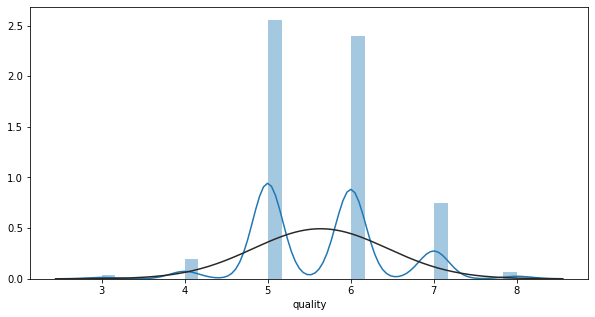

In [7]:
plt.figure(figsize = (10,5))
sns.distplot(Y, fit=norm)

# variables histograms before normalization:

##### The blue line is kernel density estimator.
##### The black line (norm) is maximum likelihood gaussian distribution fit.

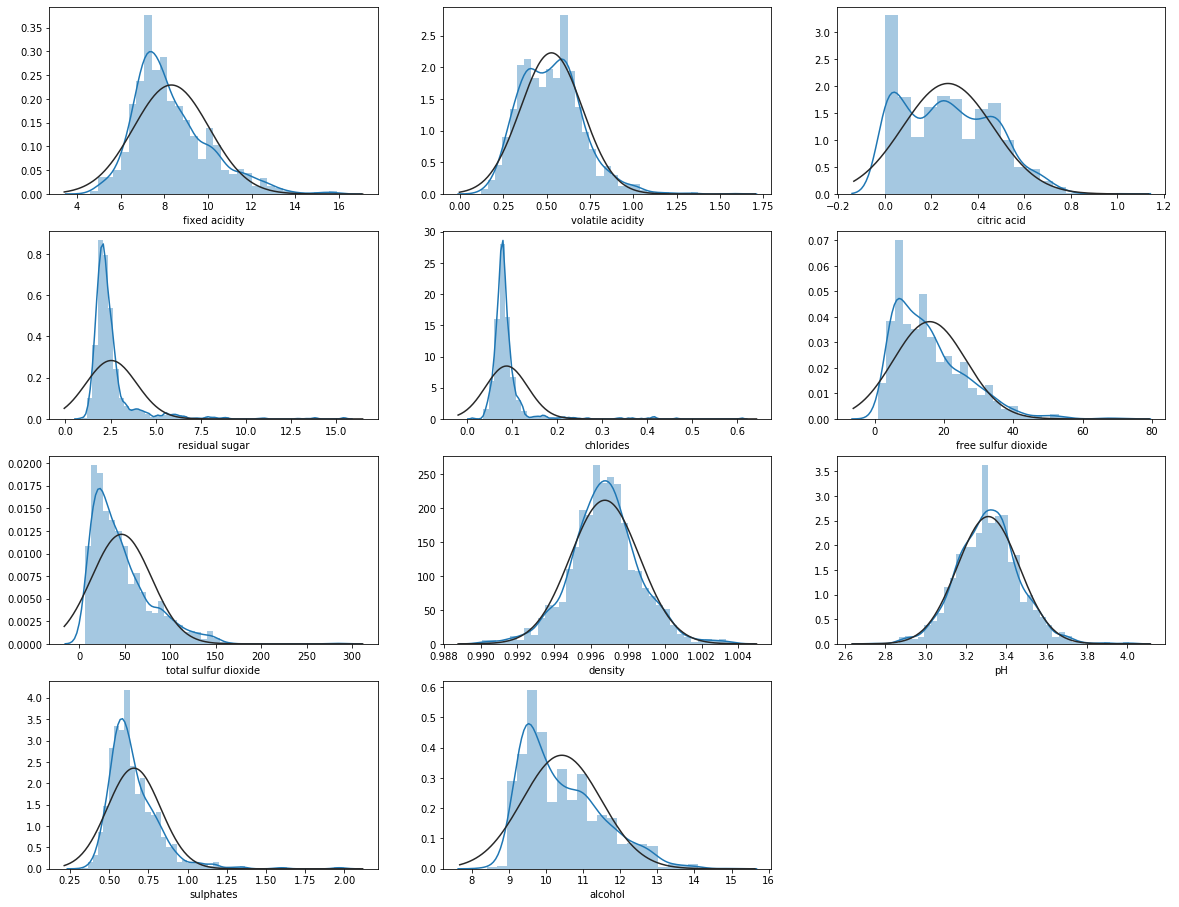

In [8]:
plt.figure(figsize = (20,20))

for i in range(1,12):
    plt.subplot(5,3,i)
    sns.distplot(X[X.columns[i-1]], fit=norm)
# fit=norm
# hist=False

## variables normalization using z-score:

In [9]:
normalized_X = (X - X.mean())/X.std()

# variables histograms after normalization:

##### The blue line is kernel density estimator.
##### The black line (norm) is maximum likelihood gaussian distribution fit.

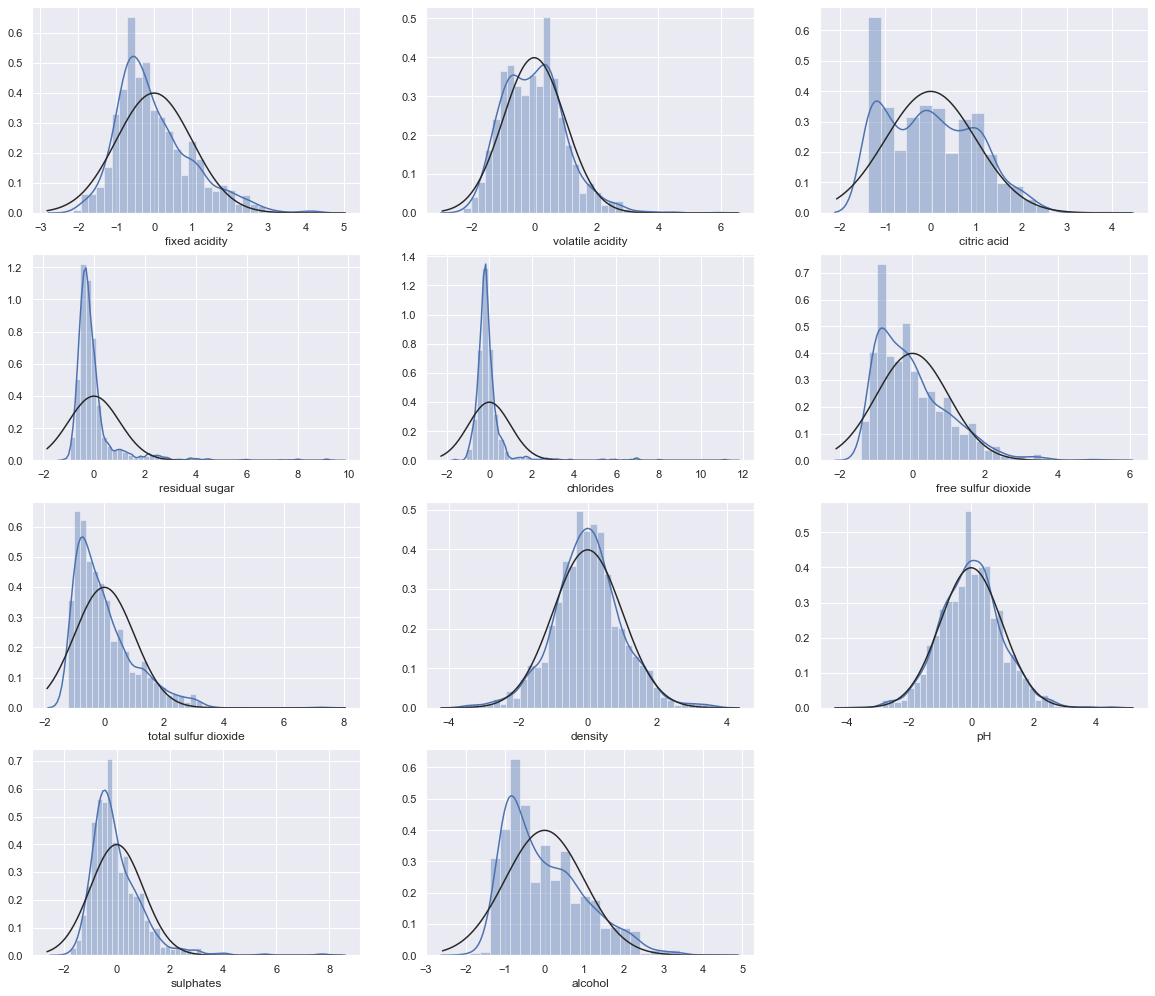

In [129]:
plt.figure(figsize = (20,22))

for i in range(1,12):
    plt.subplot(5,3,i)
    sns.distplot(normalized_X[normalized_X.columns[i-1]], fit=norm)
# fit=norm
# hist=False

# Cutting the data to training and test randomly:

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(normalized_X, Y, test_size=0.18, random_state=42)

In [12]:
normalized_x_train = (X_train - X_train.mean())/X_train.std()

normalized_x_test = (X_test - X_test.mean())/X_test.std()

# Heat map of the dependence of each feature on the othe ones.

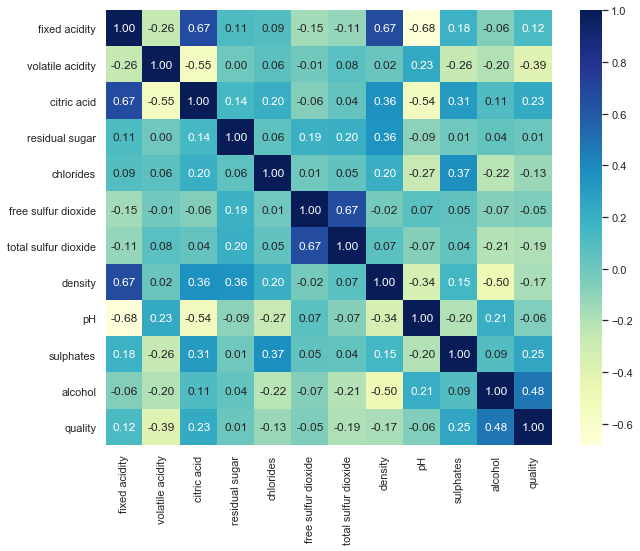

In [13]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap="YlGnBu",
            annot=True,
           fmt=".2f")
plt.show()

In [95]:
corr = X.corr()
dependences = []
corr_list = corr.values.tolist()
for i in range(len(corr_list)):
    del corr_list[i][i]
for row in corr_list:
    dep = 0
    for i in range(len(row)):
        dep += abs(row[i])
    dependences.append(dep)
dep_df = pd.DataFrame(dependences)
dep_df['attribute'] = corr.columns.T
dep_df = dep_df.sort_values(by=[0], ascending=False)
attributes = dep_df['attribute'].tolist()
dep_df = pd.DataFrame(dep_df[0]).T
dep_df.columns = attributes
dep_df

,fixed acidity,citric acid,pH,density,alcohol,volatile acidity,sulphates,total sulfur dioxide,chlorides,free sulfur dioxide,residual sugar
0,2.998991,2.997635,2.69135,2.690537,1.707545,1.679054,1.666903,1.529644,1.525458,1.298943,1.194497


In [113]:
class Combination:
    def __init__(self, att_comb, dependence):
        self.att_comb = att_comb
        self.dependence = dependence
    
    def get_att_comb(self):
        return self.att_comb
    
    def get_dependence(self):
        return self.dependence
    
    def get_number_of_atributes(self):
        return len(self.att_comb)
    
#     def __repr__(self):
#         return 'combination: ' + self.att_comb.__repr__ + ' max dependence: ' + self.dependence.__repr__

In [109]:
def calc_dependence(dependences: list, combination) -> float:
    dep = 0
    for i in combination:
        dep += abs(dependences[i])
    return dep

## Max dependence of attribute in the other ones, depending on the number of attributes:

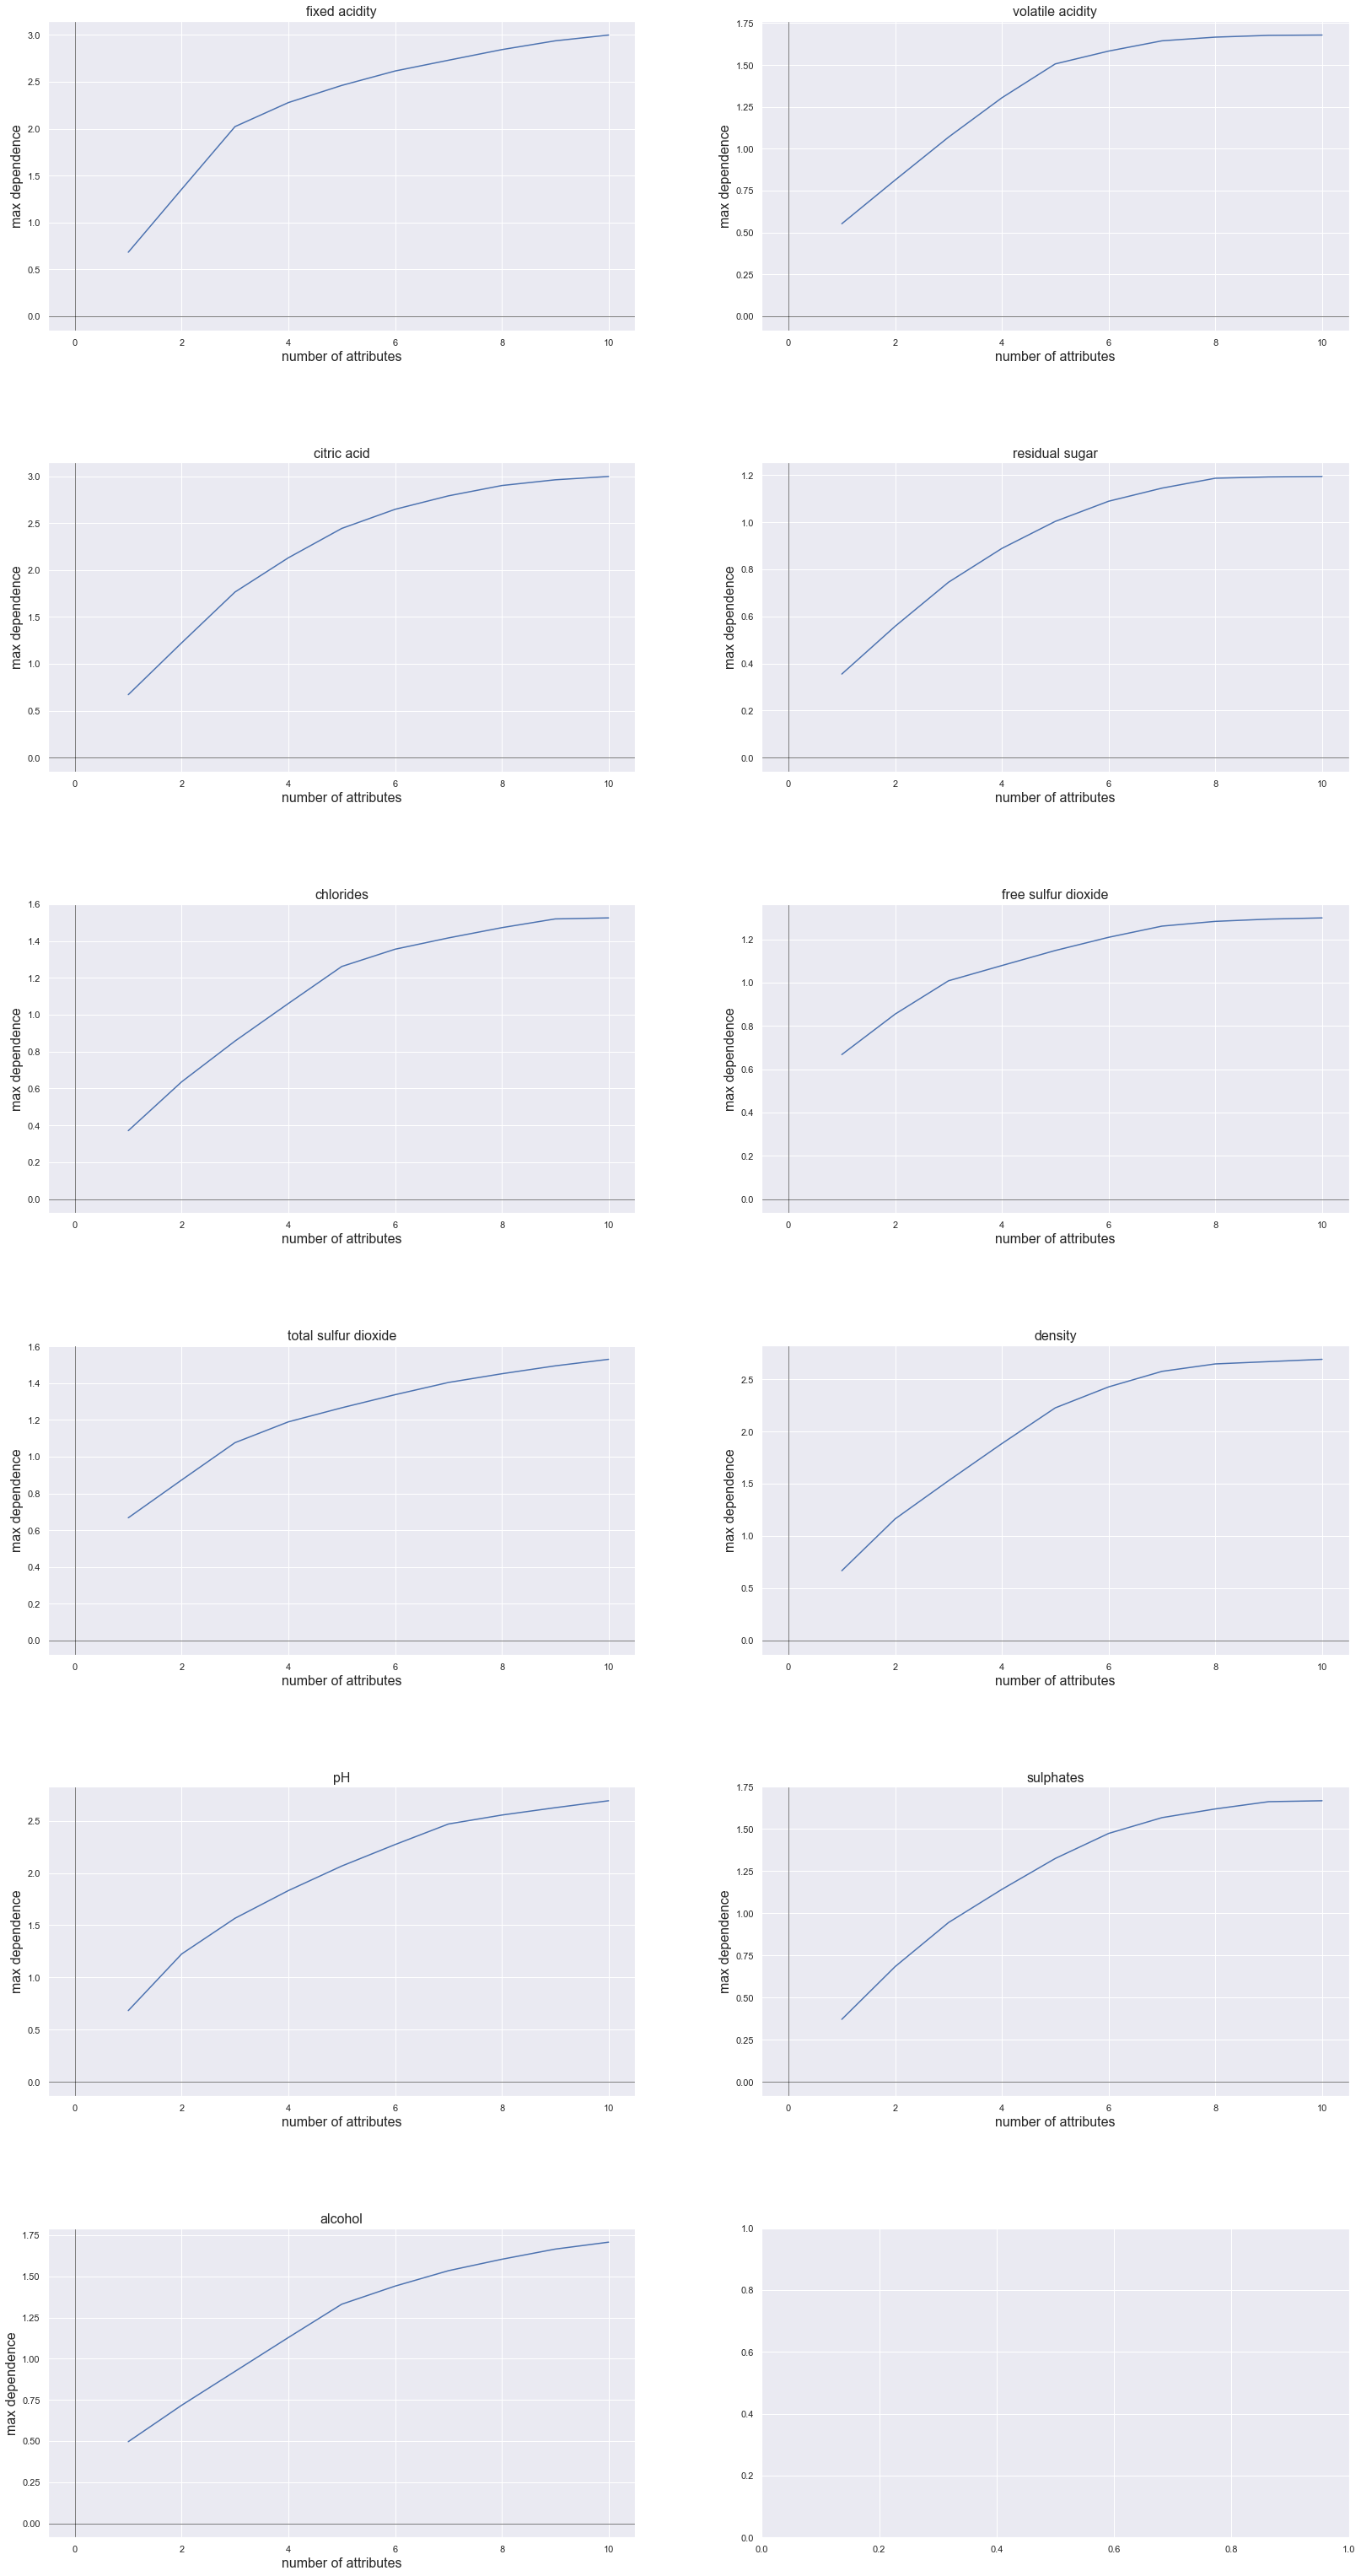

In [182]:
corr_list = corr.values.tolist()
for i in range(len(corr_list)):
    del corr_list[i][i]
corr_df = pd.DataFrame(corr_list).T
corr_df.columns = corr.columns.tolist()
attribute_combinations_list = []
for attribute in corr_df.columns.tolist():
    # combinations_list is list of Combinations:
    dependences = corr_df[attribute].T.values.tolist()
    combinations_list = []
    for i in range(10):
        max_dependence = 0
        max_combination = ()
        for combination in combinations(range(10), i + 1):
            if calc_dependence(dependences, combination) > max_dependence:
                max_dependence = calc_dependence(dependences, combination)
                max_combination = combination
        combinations_list.append(Combination(max_combination, max_dependence))
    attribute_combinations_list.append((attribute, combinations_list))

fig, axs = plt.subplots(6, 2, figsize=(25, 45))
for attribute in range(len(corr_df.columns.tolist())):
    xs = [i + 1 for i in range(10)]
    ys = [comb.get_dependence() for comb in attribute_combinations_list[attribute][1]]
    axs[int(attribute / 2), int(attribute % 2)].set_xlabel('number of attributes', fontsize=16)
    axs[int(attribute / 2), int(attribute % 2)].set_ylabel('max dependence', fontsize=16)
    axs[int(attribute / 2), int(attribute % 2)].axhline(0, lw=0.5, color='black')
    axs[int(attribute / 2), int(attribute % 2)].axvline(0, lw=0.5, color='black')
    axs[int(attribute / 2), int(attribute % 2)].set_title(attribute_combinations_list[attribute][0], fontsize=16)
    axs[int(attribute / 2), int(attribute % 2)].plot(xs, ys)
fig.tight_layout(pad=10.0)
    
# for comb in attribute_combinations_list[0][1]:
#     print('for ' + str(comb.get_number_of_atributes()) + ' attributes combination: ')
#     print('the maximum dependence is: ' + str(comb.get_dependence()) + ', with the combination: ' + str(comb.get_att_comb()))

# Question 1.a - Regrestion
we'll try out three regresion models and compair them.
1. linear regrestion
2. SVM Regresor
3. neural network regresor

## Linear Regrestion

In [27]:
reg = LinearRegression().fit(X_train, Y_train)
print(reg.score(X_test, Y_test))

a=reg.predict(X_train)
train_rmse= (mean_squared_error(a,Y_train)) ** 0.5
print(train_rmse)
b=reg.predict(X_test)
test_rmse= (mean_squared_error(b,Y_test)) ** 0.5
test_rmse

0.39164204678625897
0.649807104391163


0.6278445092428936

## Polinomial Regresion

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

model = model.fit(X_train, Y_train)
# model.named_steps['linear'].coef_

In [29]:
from sklearn.metrics import mean_squared_error
a = model.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print(train_rmse)
b=  model.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print(test_rmse)

0.6081761406236939
0.6244258847321539


## SVM Regresor

In [30]:
regr_rbf = svm.SVR(kernel='rbf')
regr_lin = svm.SVR(kernel='linear')
regr_poly =svm.SVR(kernel='poly', degree = 2)
regr_rbf.fit(X_train, Y_train)
regr_lin.fit(X_train, Y_train)
regr_poly.fit(X_train, Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [31]:
print('regr_rbf score = ',regr_rbf.score(X_train,Y_train))
a = regr_rbf.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('regr_rbf train_rmse = ',train_rmse)
b=  regr_rbf.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('regr_rbf test_rmse = ', test_rmse)

print('regr_lin score = ',regr_lin.score(X_train,Y_train))
a = regr_lin.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('regr_lin train_rmse = ',train_rmse)
b=  regr_lin.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('regr_lin test_rmse = ', test_rmse)

print('regr_poly score = ',regr_poly.score(X_train,Y_train))
a = regr_poly.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('regr_poly train_rmse = ',train_rmse)
b=  regr_poly.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('regr_poly test_rmse = ', test_rmse)

regr_rbf score =  0.5300717198949797
regr_rbf train_rmse =  0.5535556306518078
regr_rbf test_rmse =  0.60321179635412
regr_lin score =  0.3409429629848918
regr_lin train_rmse =  0.6555517524448167
regr_lin test_rmse =  0.6346942773306186
regr_poly score =  0.1267536876003591
regr_poly train_rmse =  0.7545948938381316
regr_poly test_rmse =  0.8391201416038251


## Neural Network Regresor 

In [32]:
NN_model = Sequential()
NN_model.add(Dense(5, input_dim=11, activation= "relu"))
NN_model.add(Dense(4, activation= "selu"))
NN_model.add(Dense(2, activation= "selu"))
NN_model.add(Dense(1))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
NN_model.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
#history = NN_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
history = NN_model.fit(X_train, Y_train, epochs=100, validation_split=0.2)


Train on 1048 samples, validate on 263 samples
Epoch 1/100
1048/1048 [==============================] - 0s 193us/step - loss: 33.4127 - mean_squared_error: 33.4127 - val_loss: 30.8849 - val_mean_squared_error: 30.8849
Epoch 2/100
1048/1048 [==============================] - 0s 56us/step - loss: 27.9690 - mean_squared_error: 27.9690 - val_loss: 25.6610 - val_mean_squared_error: 25.6611
Epoch 3/100
1048/1048 [==============================] - 0s 49us/step - loss: 23.2468 - mean_squared_error: 23.2468 - val_loss: 21.3892 - val_mean_squared_error: 21.3892
Epoch 4/100
1048/1048 [==============================] - 0s 53us/step - loss: 19.2334 - mean_squared_error: 19.2334 - val_loss: 17.5029 - val_mean_squared_error: 17.5029
Epoch 5/100
1048/1048 [==============================] - 0s 50us/step - loss: 15.4245 - mean_squared_error: 15.4245 - val_loss: 13.6866 - val_mean_squared_error: 13.6866
Epoch 6/100
1048/1048 [==============================] - 0s 48us/step - loss: 11.7374 - mean_squared_

1048/1048 [==============================] - 0s 46us/step - loss: 0.4095 - mean_squared_error: 0.4095 - val_loss: 0.3401 - val_mean_squared_error: 0.3401
Epoch 97/100
1048/1048 [==============================] - 0s 48us/step - loss: 0.4089 - mean_squared_error: 0.4089 - val_loss: 0.3400 - val_mean_squared_error: 0.3400
Epoch 98/100
1048/1048 [==============================] - 0s 49us/step - loss: 0.4092 - mean_squared_error: 0.4092 - val_loss: 0.3402 - val_mean_squared_error: 0.3402
Epoch 99/100
1048/1048 [==============================] - 0s 44us/step - loss: 0.4093 - mean_squared_error: 0.4093 - val_loss: 0.3390 - val_mean_squared_error: 0.3390
Epoch 100/100
1048/1048 [==============================] - 0s 45us/step - loss: 0.4075 - mean_squared_error: 0.4075 - val_loss: 0.3396 - val_mean_squared_error: 0.3396


In [34]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


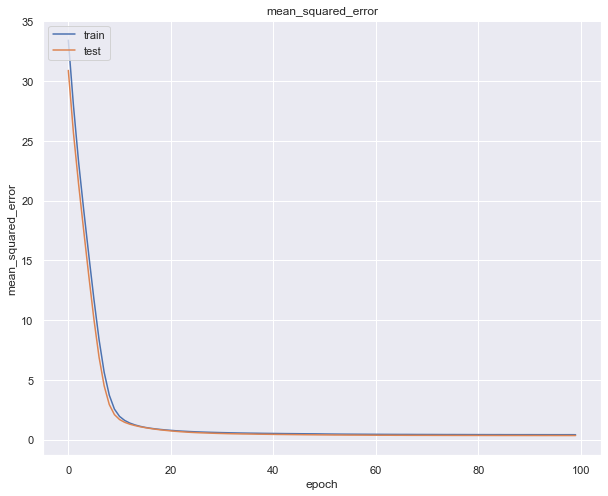

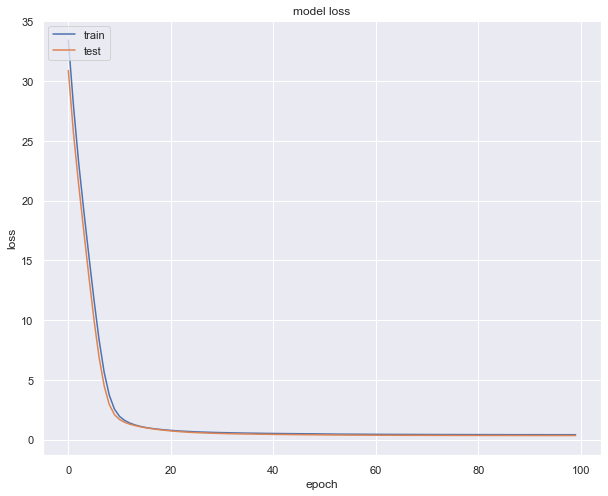

In [35]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
a = NN_model.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('NN train_rmse = ',train_rmse)
b=  NN_model.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('NN test_rmse = ', test_rmse)

NN train_rmse =  0.626593674411731
NN test_rmse =  0.6512096715238489


In [37]:
a = NN_model.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('NN train_rmse = ',train_rmse)
b=  NN_model.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('NN test_rmse = ', test_rmse)

NN train_rmse =  0.626593674411731
NN test_rmse =  0.6512096715238489


# Question 1.b - Clustering
we'll try out three clustering methoods and compair them.
1. DBSCAN
2. K-Means
3. GMM

In [38]:
plt.figure(figsize = (12,7))

<Figure size 864x504 with 0 Axes>

<Figure size 864x504 with 0 Axes>

In [39]:
def points_for_cluster_df(clustering_labels):
    hist_dictionary = {}
    for i in clustering_labels:
        if str(i) in hist_dictionary:
            hist_dictionary[str(i)] = hist_dictionary[str(i)] + 1
        else:
            hist_dictionary[str(i)] = 1
    clusters_names_numeric = [int(x) for x in hist_dictionary.keys()]
    clusters_names_numeric.sort()
    clusters_names = [str(name) for name in clusters_names_numeric]
    points_amount_for_cluster = [hist_dictionary[x] for x in clusters_names]
    clustering_hist_df = pd.DataFrame([points_amount_for_cluster])
    clustering_hist_df.columns = clusters_names
    return clustering_hist_df

In [40]:
def plot_db_and_silhouette_score(clustering_method, clusters, db_scores, s_scores):
    plt.plot(clusters, db_scores, color='purple',label='Davies Bouldin score')
    plt.plot(clusters, s_scores, color='blue',label='Silhouette score')
    plt.title(clustering_method + ' clustering Davies Bouldin and Silhouette score depending on clusters number')
    plt.ylabel('Silhouette score, Davies Bouldin score')
    plt.xlabel('clusters')
    plt.axhline(0, lw=0.5, color='black')
    plt.axvline(0, lw=0.5, color='black')
    plt.legend()

# Birch:

In [41]:
s_scores = []
db_scores = []
clusters = range(2,31)
for i in clusters:
    br = Birch(n_clusters=i).fit(normalized_x_train)
    s_scores.append(silhouette_score(normalized_x_train, br.labels_))
    db_scores.append(davies_bouldin_score(normalized_x_train, br.labels_))
None
print('done')

done


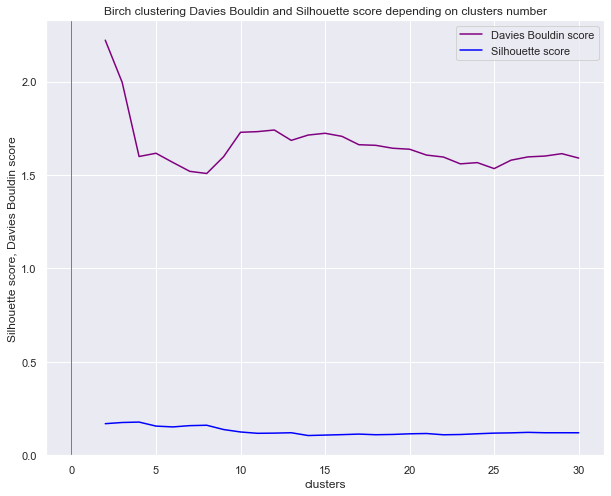

In [42]:
plot_db_and_silhouette_score('Birch', clusters, db_scores, s_scores)

### Optimize Birch clustering with 7 clusters:

In [54]:
optimize_br = Birch(n_clusters=7).fit(normalized_x_train)
points_for_cluster_df(optimize_br.labels_)

,0,1,2,3,4,5,6
0,243,481,241,16,174,132,24


# Kmeans:

In [44]:
s_scores = []
db_scores = []
clusters = range(2,31)
for i in clusters:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(normalized_x_train)
    s_scores.append(silhouette_score(normalized_x_train, kmeans.labels_))
    db_scores.append(davies_bouldin_score(normalized_x_train, kmeans.labels_))
None

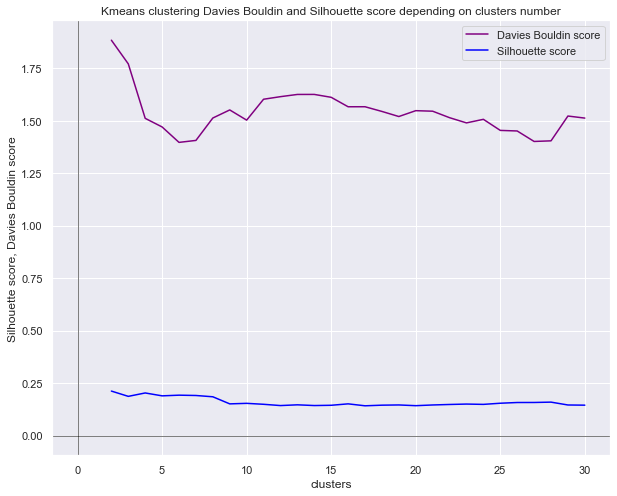

In [45]:
plot_db_and_silhouette_score('Kmeans', clusters, db_scores, s_scores)

### Optimize Kmeans clustering 6 clusters:

In [46]:
optimize_km = KMeans(n_clusters=6, random_state=0).fit(normalized_x_train)
points_for_cluster_df(optimize_km.labels_)

,0,1,2,3,4,5
0,27,290,255,24,421,294


# MeanShift:

### Optimize MeanShift clustering using estimate_bandwidth:

In [47]:
optimize_bandwidth = estimate_bandwidth(normalized_x_train)
optimize_ms = MeanShift(bandwidth=optimize_bandwidth).fit(normalized_x_train)
points_for_cluster_df(optimize_ms.labels_)

,0,1,2,3,4,5,6,7,8,9
0,1250,20,12,4,7,10,2,1,1,4


In [48]:
print(optimize_bandwidth)

3.5923349491800294


# Predict qualities with the clasters mean quality:

In [55]:
def mean_quality_for_cluster_dictionary(df, clustering):
    mean_qualities = {}
    for i in df[clustering].unique():
        mean_qualities[i] = df[df[clustering] == i]['quality'].mean()
    return mean_qualities

In [56]:
def cluster_score(cluster_quality_dict: dict, test_cluster_lables: pd.Series, real_test_values: pd.Series):
    predicted_qualities = []
    for i in test_cluster_lables:
        predicted_qualities.append(cluster_quality_dict[i])
    predicted_qualities = pd.Series(predicted_qualities)
    return mean_squared_error(predicted_qualities, real_test_values) ** 0.5

In [57]:
train_with_clusters = normalized_x_train.copy()
train_with_clusters['quality'] = Y_train
# MeanShift:
train_with_clusters['ms_cluster'] = optimize_ms.labels_
ms_qualities_dict = mean_quality_for_cluster_dictionary(train_with_clusters,'ms_cluster')
# Birch:
train_with_clusters['br_cluster'] = optimize_br.labels_
br_qualities_dict = mean_quality_for_cluster_dictionary(train_with_clusters,'br_cluster')
# Kmeans
train_with_clusters['km_cluster'] = optimize_km.labels_
km_qualities_dict = mean_quality_for_cluster_dictionary(train_with_clusters,'km_cluster')

In [58]:
print('ms_qualities_dict: ',ms_qualities_dict)
print()
print('br_qualities_dict: ',br_qualities_dict)
print()
print('km_qualities_dict: ',km_qualities_dict)

ms_qualities_dict:  {0: 5.6288, 9: 5.25, 2: 5.333333333333333, 3: 5.5, 1: 5.35, 4: 5.857142857142857, 6: 5.5, 5: 6.3, 8: 7.0, 7: 4.0}

br_qualities_dict:  {1: 5.367983367983368, 5: 5.954545454545454, 6: 5.291666666666667, 2: 5.941908713692946, 0: 5.2592592592592595, 4: 6.252873563218391, 3: 5.1875}

km_qualities_dict:  {4: 5.327790973871734, 2: 6.145098039215687, 0: 5.592592592592593, 1: 5.937931034482759, 5: 5.3231292517006805, 3: 5.333333333333333}


In [59]:
test = normalized_x_test.copy()
test['quality'] = Y_test
# MeanShift:
ms_test_labels = optimize_ms.predict(normalized_x_test)
print('Mean Shift score: ', cluster_score(ms_qualities_dict, ms_test_labels, test['quality']))

# Birch:
br_test_labels = optimize_br.predict(normalized_x_test)
print('Birch score: ', cluster_score(br_qualities_dict, br_test_labels, test['quality']))

# Kmeans
km_test_labels = optimize_km.predict(normalized_x_test)
print('Kmeans score: ', cluster_score(km_qualities_dict, km_test_labels, test['quality']))

Mean Shift score:  0.803208875020888
Birch score:  0.7018921042664663
Kmeans score:  0.7111529859154113
